# Introduction
***
A random forest is an example of an ensemble learning method. An **ensemble method** is a way to aggregate less predictive base models to produce a better predictive model. Random forests use multiple decision trees together in order to produce a more generalized model by reducing the tendency to overfit. 

## Theory
***
**Feature Bagging** - (bootstrap aggregating) is a method of selecting a random number of samples from the original set **with replacement**. For **feature bagging**, the original set of features is randomly sampled and used in separate trees (without replacement - having the same feature twice is redundant). Randomly selecting which features will be used by which trees works to decrease the correlation among the trees. 

**Aggregation** - average the outputs of several crappy trees to create a better random forest. Or take the majority vote for classification.

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [59]:
data_path = "../data/House_Prices_Advanced/train.csv"
data = pd.read_csv(data_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Columns we will use:
* **OverallQual** - a categorical variable from 1-10 representing the overall qualtiy of the house 
* **GrLivArea** - Above ground living area in feet
* **GarageCars** - integer, size of garage in terms of car capacity

In [60]:
X = data[['OverallQual', 'GrLivArea', 'GarageCars']]
y = data['SalePrice']

The cost function we're going to use it Root Mean Square Error:
$$\textrm{RMSE}=\sqrt{\frac{1}{m}\sum_{i=1}^m(y^{(i)}-h(x^{(i)}))^2}$$

In [61]:
from sklearn.metrics import mean_squared_error


def rmse(h, y):
    return np.sqrt(mean_squared_error(h, y))

Not Fitted Error when Using sklearn's graphviz. After fitting a random forest regressor, using export graphviz on the fitted regressor will not work. This is because inside `export_graphviz`, there is a `check_is_fitted( decision_tree, 'tree_')`. This means that it is trying to access the `tree_` attribute of the decision tree, which exists for a DecisionTreeClassifier. This attribute does not exist for a RandomForestClassifier. So, access the decision tree using the `random_forest.estimators_` attribute.

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import os

RANDOM_SEED=1 

# random forest with 1 estimator is a single tree
regressor = RandomForestRegressor( bootstrap=True,
    n_estimators=1,
    max_depth=2,
    random_state=RANDOM_SEED)

regressor = regressor.fit(X,y)
print("Feature importances: \n",regressor.feature_importances_)

outfileName = 'decision_tree.dot'
# send the decision tree repr to dot file 
export_graphviz(regressor.estimators_[0], out_file=outfileName)
command_string = 'dot -Tpng {} -o tree.png'.format(outfileName)
# run the above command to convert dot file to png
os.system( command_string )

Feature importances: 
 [0.88886309 0.11113691 0.        ]


0

![Decision Tree Classifier](tree.png)

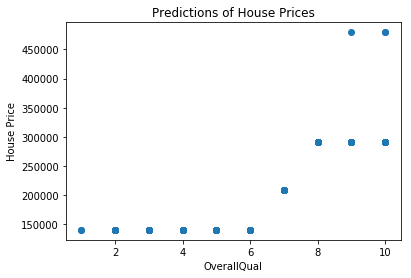

In [63]:
test_data_path = "../data/House_Prices_Advanced/test.csv"
test_data = pd.read_csv(test_data_path)[['OverallQual', 'GrLivArea', 'GarageCars']].dropna()
xs = test_data['OverallQual']
predictions = regressor.predict(test_data)
plt.scatter(xs,predictions)
plt.xlabel("OverallQual")
plt.ylabel("House Price")
plt.title("Predictions of House Prices")
plt.show()

# Decision Tree Class
***
1. **indxs** - keep track of which indices of the original set goes to the right, and which go to the left tree. Every tree has this parameter that stores the indices of the observations it contains. Predictions are made by averaging these rows
2. **min_leaf** - minimum row samples required to create a split. Every leaf node will have a number of observations that is smaller than min_leaf because they are the terminal nodes.
3. **depth** - max depth or max number of splits possible within each tree

Trees are **recursive data structres**. Out `Node` class represents a single node in our tree. We are doing a binary tree, so each division in the model will have two possible outcomes - you either go to the left or the right. Dividing on the chosen split divides the data into two sets. 

`idxs` stores a subset of the indices of the data this `Node` is working with

The prediction is based on the `value` this `Node` holds. To minimize the L2 loss, the bayes decision function is the average of the data points that are in this `Node`. 

In [64]:
class DecisionTreeRegressor:
  
  def fit(self, X, y, min_leaf = 5):
    self.dtree = Node(X, y, np.array(np.arange(len(y))), min_leaf)
    return self
  
  def predict(self, X):
    return self.dtree.predict(X.values)

In [65]:
class Node:

    def __init__(self, X, y, idxs, min_leaf=5):
        """
        Inputs:
        X - (DataFrame) the entire dataset
        y - (Series) the entire set of labels
        idxs - (array) the subset of indices this Node is working on
        min_leaf - (int) the minimum number of observations to split a Node
        """
        self.X = X 
        self.y = y
        self.idxs = idxs 
        self.min_leaf = min_leaf
        self.row_count = len(idxs)
        self.col_count = X.shape[1]
        self.val = np.mean(y[idxs])
        # leaf nodes do not have scores, so it should be infinity 
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        """
        Loop over the columns to determine the best feature to split on, and its best splitting threshold. 
        Then, create children node. 
        
        """
        for c in range(self.col_count): 
            self.find_better_split(c)
        if self.is_leaf: 
            return
        
        x = self.X.values[self.idxs, self.split_col]
        lhs = x[x <= self.split]
        rhs = x[x > self.split]
        # TODO: why not just pass self.X[self.lhs_indxs] and self.X[self.rhs_indxs]?
        self.lhs = Node(self.X, self.y, self.idxs[lhs], self.min_leaf)
        self.rhs = Node(self.X, self.y, self.idxs[rhs], self.min_leaf)
        
    def find_better_split(self, split_col):
        """
        Given a fixed column number to split on, find the best splitting value for x.
        Set the attributes for this node so it knows the splitting feature and the splitting threshold.
        
        This is the minimization routine. Better design would probably be to refactor this into generic 
        minimization and then return the splitting column, score and value
        """
      
        x = self.X.values[self.idxs, split_col]

        # Note: this is the minimization routine
        # for each possible splitting index
        for r in range(self.row_count):
            lhs = (x <= x[r])
            rhs = (x > x[r])
            # if either of the children have few enough points to make it a terminal node
            if rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf: 
                # go back to condition 
                continue
            # compute score of current split
            curr_score = self.find_score(lhs, rhs)
            if curr_score < self.score: 
                self.split_col = split_col
                self.score = curr_score
                self.split = x[r]
                
    def find_score(self, lhs, rhs):
        # want to minimize the weighted average of the standard deviations 
        y = self.y[self.idxs]
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        return lhs_std * lhs.sum() + rhs_std * rhs.sum()
                
    @property
    def is_leaf(self): 
        return self.score == float('inf')                

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: 
            return self.val
        if xi[self.split_col] <= self.split:
            node = self.lhs
        else:
            self.rhs
        return node.predict_row(xi)

In [66]:
regressor = DecisionTreeRegressor().fit(X, y)

IndexError: index 1694 is out of bounds for axis 1 with size 422

In [ ]:
preds = regressor.predict(test_data)